# The HFM library - A fast marching solver with adaptive stencils

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Input and output

This notebook illustrates the distinction between 'raw' and 'smart' input to the HFM library, and how to save the those for debugging purposes.

*Update.* 'raw' input is now deprecated, and 'smart' input becomes default. This notebook is only left for non-regression tests.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Input and output](#1.-Input-and-output)
    * [1.1 Raw data](#1.1-Raw-data)
    * [1.2 Smart data (Pre- and post-processed)](#1.2-Smart-data-(Pre--and-post-processed))
  * [2. Saving data](#2.-Saving-data)
    * [2.1 Exporting raw data](#2.1-Exporting-raw-data)
    * [2.2 Importing raw data](#2.2-Importing-raw-data)
    * [2.3 Turning smart input into raw input](#2.3-Turning-smart-input-into-raw-input)
  * [3. Input dictionary](#3.-Input-dictionary)
  * [4. Caching data](#4.-Caching-data)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('SmartIO','FMM'))

In [2]:
from agd import Eikonal
from agd import Metrics

In [3]:
# We will also need some standard python libraries.
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

## 1. Input and output

The following example is taken from the notebook on the Fisher-Rao distance [link](FisherRao.ipynb)

In [4]:
hfmIn = Eikonal.dictIn({'mode':'cpu_raw'})
hfmIn['model'] = 'Riemann2' # Adequate model for two dimensional Riemannian metrics.

# Create the parameter space
n=100
hfmIn.SetRect(sides=[[-2,2],[0,1]],dimx=4*n)
mu,sig = hfmIn.Grid()

hfmIn['seed'] = [0,0.3] # A single seed
hfmIn.SetUniformTips((4,3))

hfmIn['exportValues'] = 1
hfmIn['order'] = 2

In [5]:
tips = hfmIn['tips']

### 1.1 Raw data

The HamiltonFastMarching (HFM) library only expects and returns data in the following basic formats: 
- numpy arrays with elements of type *float64*
- strings

Furthermore, the dimensions of the arrays corresponding to physical space are expected to be the last ones. This convention is opposite to the one taken in the agd library, where the physical dimensions come first. For that reason it is not always convenient to input and output data in raw format

In [6]:
hfmIn['metric'] = np.stack( (1./sig**2, 0.*sig, 2./sig**2), 2)

In [7]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.02402 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


The geodesics are also returned in a raw format, with their points concatenated, and their lengths returned as a separate variable. A helper function is provided to pack them more appropriately.

In [8]:
hfmOut['geodesicPoints']

array([[-1.5       ,  0.16666667],
       [-1.4982569 ,  0.17088473],
       [-1.49623159,  0.17570491],
       ...,
       [ 0.01030596,  0.31783145],
       [ 0.00803683,  0.31255899],
       [ 0.005     ,  0.305     ]])

In [9]:
hfmOut['geodesicLengths']

array([587., 543., 534., 158., 161., 238., 153., 159., 238., 585., 542.,
       532.])

In [10]:
geodesics = Eikonal.run_detail.GetGeodesics(hfmOut)

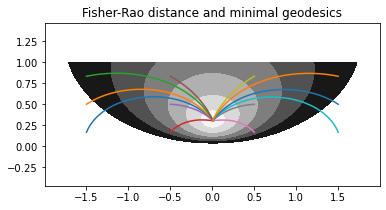

In [11]:
fig = plt.figure(figsize=[6,3]); plt.title('Fisher-Rao distance and minimal geodesics'); plt.axis('equal'); 
plt.contourf(mu,sig,hfmOut['values'],cmap='Greys',levels=np.linspace(0,3,7));  # Display the value function. 

for geo in geodesics:  plt.plot(*geo)

### 1.2 Smart data (Pre- and post-processed)

For convenience, an optional pre- and post-processing of the communication with the HFM library is proposed. 
This is referred to as a smart run.

In [12]:
hfmInS = Eikonal.dictIn({**hfmIn,'mode':'cpu'})
riemann = Metrics.Riemann.from_diagonal([1./sig**2,2./sig**2])
hfmInS['metric'] = riemann

In [13]:
hfmOutS = hfmInS.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.027852 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


The geodesics are returned as a list of arrays, with appropriate shape.

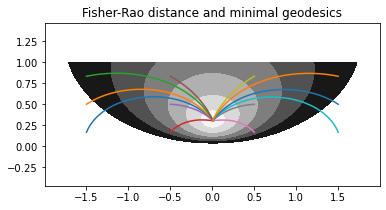

In [14]:
fig = plt.figure(figsize=[6,3]); plt.title('Fisher-Rao distance and minimal geodesics'); plt.axis('equal'); 
plt.contourf(mu,sig,hfmOutS['values'],cmap='Greys',levels=np.linspace(0,3,7));  # Display the value function. 

for geo in hfmOutS['geodesics']:  plt.plot(*geo)

## 2. Saving data

One can save in a file the data fed to HFMUtils library, in a format that can be directly read by the FileHFM library. This is particularly useful for debugging the C++ library.


The following functions export and import raw data.

In [15]:
from agd.Eikonal.FileIO import RawToFiles,FilesToRaw

### 2.1 Exporting raw data

In [16]:
help(RawToFiles)

Help on function RawToFiles in module agd.Eikonal.FileIO:

RawToFiles(params, prefix='input')
    Exports a dictionary to a pair of files, whose name begins with 'prefix'.
    The dictionnary elements must by strings, scalars, and numpy arrays.
    The resulting files are readable by the HFM library.



In [17]:
dataDir = "InPreparation/SmartIO"
if os.path.isfile('Notebooks_FMM/SmartIO.ipynb'): dataDir = os.path.join('Notebooks_FMM',dataDir)

In [18]:
RawToFiles(hfmIn,os.path.join(dataDir,"myinput"))
RawToFiles(hfmOut,os.path.join(dataDir,"myinput"))

In [19]:
os.listdir(dataDir)

['myoutput_Format.txt',
 'myoutput_Data.dat',
 'myinput_Data.dat',
 'myinput_Format.txt']

### 2.2 Importing raw data

In [20]:
help(FilesToRaw)

Help on function FilesToRaw in module agd.Eikonal.FileIO:

FilesToRaw(prefix='output')
    Imports a pair of files, whose name begins with 'prefix', into a dictionary.
    These files may be produced by the HFM library.



In [21]:
def npdict_equal(dict0,dict1):
    """Tests if two dictionnaries, containing numpy arrays, are equal.
    CPU time reports are ignored, as well as log."""
    if dict0.keys()!=dict1.keys(): return False,"keys"

    for key in dict0:
        if isinstance(dict0[key],np.ndarray):
            if not np.array_equiv(dict0[key],dict1[key]): return False,key
        elif key.endswith("CPUTime") or key=='log':
            pass
        else:
            if not dict0[key]==dict1[key]: return False,key
    return True

In [22]:
assert npdict_equal(hfmIn,FilesToRaw(os.path.join(dataDir,"myinput")))
assert npdict_equal(hfmOut,FilesToRaw(os.path.join(dataDir,"myoutput")))

### 2.3 Turning smart input into raw input

The input fields to a smart run often involve types which cannot be exported with the `FileIO` library. In addition, the resulting files cannot be read by the HFM binary executables. However, a smart run can be early aborted to either:
- return the raw input
- return the raw output

The resulting raw data can be saved as in the previous subsection, and processed by the HFM executables.

In [23]:
hfmInR = hfmInS.Run(returns='in_raw')
hfmOutR = hfmInS.Run(returns='out_raw')

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.022531 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [24]:
assert(npdict_equal(hfmInR,hfmIn))
assert(npdict_equal(hfmOutR,hfmOut))

## 3. Input dictionary

We use as input a dictionary like structure, with a few additional functions.

In [25]:
hfmIn = Eikonal.dictIn()

The `dictIn` class holds an instance of a python dictionary.

In [26]:
isinstance(hfmIn.store,dict)

True

In [27]:
hfmIn['model'] = 'Riemann2'
hfmIn['seed'] = [0,0.3]
hfmIn['exportValues'] = True

The single `seed`, is converted to a list of `seeds`, and the corresponding value is cast to a numpy array.

In [28]:
hfmIn

dictIn({'arrayOrdering': 'RowMajor', 'model': 'Riemann2', 'seeds': array([[0. , 0.3]]), 'exportValues': True})

Some of the commonly used functions of the module HFMUtils are provided as members methods.

In [29]:
n=100
hfmIn.SetRect(sides=[[-2,2],[0,1]],dimx=4*n) # Equivalent : hfmIn.update(HFMUtils.Rect(...))
mu,sig = hfmIn.Grid() # Equivalent : HFMUtils.GetGrid(hfmIn)

In [30]:
hfmIn['metric'] = Metrics.Riemann.from_diagonal([1./sig**2,2./sig**2])

In [31]:
hfmOut = hfmIn.Run() # Equivalent : HFMUtils.Run(hfmIn,smart=true)

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.015346 s.


## 4. Caching data

It is often adequate to run several times the HFM library on data that produces the same `values`. 
Indeed the solution to the discretized eikonal equation does not depend on:
- the tips from which the geodesics are backtracked.
- the variation or sensitivity fields related with automatic differentiation.

In order to save computation time, it is possible in the the subsequent runs to avoid recomputing the solution, by caching appropriate data: the solution, and some stencil information. 

Note: the HFM library will always rely the cached data, and will not check wether the solution should change - a.k.a if the seeds, cost function or metric, seeds, order, factorization method, etc have changed between runs.

In [32]:
cache = Eikonal.Cache()
hfmOut = hfmIn.Run(cache=cache)

Requesting cacheable data


Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.015401 s.
Filling cache data


Some basic output data of the HFM algorithm is saved.

In [33]:
cache.contents.keys()

dict_keys(['values', 'activeNeighs'])

We forgot to ask for the geodesics. Lets get them now.

In [34]:
hfmIn['tips']=tips
hfmIn['geodesicSolver']='ODE'
hfmOut = hfmIn.Run(cache=cache)

Providing cached data
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6


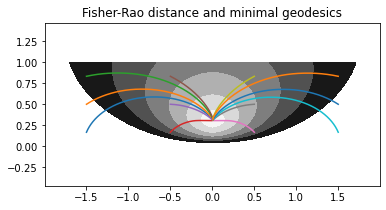

In [35]:
fig = plt.figure(figsize=[6,3]); plt.title('Fisher-Rao distance and minimal geodesics'); plt.axis('equal'); 
plt.contourf(mu,sig,hfmOut['values'],cmap='Greys',levels=np.linspace(0,3,7));  # Display the value function. 
for geo in hfmOut['geodesics']:  plt.plot(*geo)